In [2]:
import os
import torch
import torchvision
from torch import nn
import numpy as np
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from pathlib import Path
from timeit import default_timer as timer
from torch.utils.data import Subset


In [3]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [7]:
# train_dir = Path( '/content/drive/MyDrive/Disease_vs_Normal_New/train')
test_dir = Path('/kaggle/input/nehmicha-data/Disease_vs_Normal/test')

data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(320, 320)),
    # Flip the images randomly on the horizontal 
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

batch_size = 8
test_dataset = datasets.ImageFolder(test_dir, transform=data_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count())

In [10]:
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

class Binaryduper_EnsembleModel(nn.Module):
    def __init__(self, model1, model2, model3,model4):
        super(Binaryduper_EnsembleModel, self).__init__()
        self.model1 = model1
        self.model2 = model2
        self.model3 = model3
        self.model4 = model4
        
    def forward(self, x):
        x = x.to(device)
        preds1 = torch.sigmoid(self.model1(x))
        preds2 = torch.sigmoid(self.model2(x))
        preds3 = torch.sigmoid(self.model3(x))
        preds4 = torch.sigmoid(self.model4(x))
        preds = (preds1 + preds2 + preds3 + preds4) / 4
        return preds # return the predictions on the same device as input

# Load the individual models
model1 = torch.load('/kaggle/input/normal-models/Test_model_26_04_2023.Efficienet_V1_8-Batch_80.pt')
model2 = torch.load('/kaggle/input/normal-models/Test_model_26_04_2023.Resnet_V2_8-Batch._80.pt')
model3 = torch.load('/kaggle/input/binarymodels/Binary_model_30_04_2023.Resnext32x4d_V1_8-Batch (1).pt')
model4 = torch.load('/kaggle/input/binarymodels/Binary_model_30_04_2023.EfficientNetB6_V1_8-Batch_14.pt')
# Create the ensemble model
ensemble_model = Binaryduper_EnsembleModel(model1, model2, model3, model4)

# Move the ensemble model to the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ensemble_model.to(device)

# Save the ensemble model
torch.save(ensemble_model, '/kaggle/working/Binary_duper4_ensemble_model.pt')


# ensemble_model = EnsembleModel(model1, model2, model3)
# ensemble_model.load_state_dict(torch.load('/kaggle/working/ensemble_model.pt'))
# ensemble_model = ensemble_model.to(device)

criterion = nn.CrossEntropyLoss()
total_correct = 0
total_samples = 0

# Iterate over your test data and update your accuracy counters
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for inputs, labels in test_dataset:
        inputs = inputs.to(device)
        labels = torch.tensor(labels).to(device)
        outputs = model(inputs.unsqueeze(0)).to(device)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend((labels.item(),))

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)
accuracy = (cm.diagonal().sum() / cm.sum())
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)

print("Precision", precision)
print("Recall" , recall)
print("Confusion matrix:")
print(cm)
print("Accuracy:", accuracy)

Precision 0.7758620689655172
Recall 0.9375
Confusion matrix:
[[210  78]
 [ 18 270]]
Accuracy: 0.8333333333333334


In [46]:
from sklearn.metrics import precision_score, recall_score,confusion_matrix
model = torch.load("/kaggle/input/mul-modells/Multiple_model_27_04_2023.Efficienet_V2_s_8-Batch_70.pt")
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for inputs, labels in test_dataset:
        inputs = inputs.to(device)
        labels = torch.tensor(labels).to(device)
        outputs = model(inputs.unsqueeze(0)).to(device)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend((labels.item(),))

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)
accuracy = (cm.diagonal().sum() / cm.sum())
precision = precision_score(true_labels, predictions, average = 'macro')
recall = recall_score(true_labels, predictions, average = 'macro')

print("Precision", precision)
print("Recall" , recall)
print("Confusion matrix:")
print(cm)
print("Accuracy:", accuracy)

Precision 0.7003192441417241
Recall 0.7667095166606052
Confusion matrix:
[[ 36   0   8   2   1   6]
 [  0  51   1   2   0   4]
 [  5   2 245   6   2  61]
 [  0   2   5  39   0  10]
 [  0   0   1   0  42   3]
 [ 18  11 130  27   4 384]]
Accuracy: 0.7193140794223827


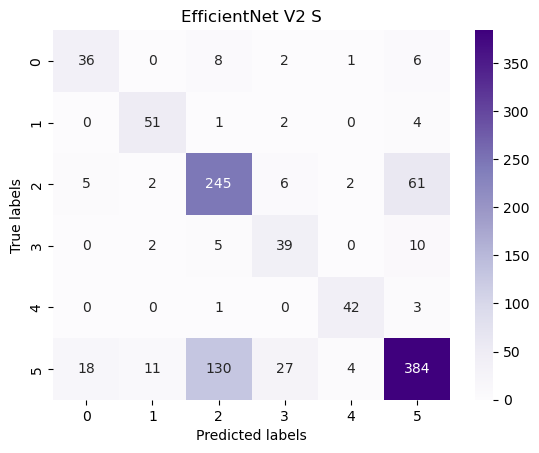

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# define your confusion matrix
matrix = cm.astype(int)


# create a heatmap of the confusion matrix
sns.heatmap(matrix, annot=True, cmap='Purples', fmt='d')

# add labels to the plot
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('EfficientNet V2 S')

# show the plot
plt.show()

In [13]:
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix

class Bin_EnsembleModel(nn.Module):
    def __init__(self,model1,model2, model3):
        super(Bin_EnsembleModel, self).__init__()
        self.model1 = model1
        self.model2 = model2
        self.model3 = model3
     
        
    def forward(self, x):
        x = x.to(device)
        preds1 = torch.sigmoid(self.model1(x))
        preds2 = torch.sigmoid(self.model2(x))
        preds3 = torch.sigmoid(self.model3(x))
 
        preds = ( preds1 + preds2 + preds3) / 3
        return preds # return the predictions on the same device as input

# Load the individual models
model1 = torch.load('/kaggle/input/binarymodels/Binary_model_30_04_2023.EfficientNetB6_V1_8-Batch_14.pt')
model2 = torch.load('/kaggle/input/binarymodels/Binary_model_30_04_2023.Resnext32x4d_V1_8-Batch (1).pt')
model3 = torch.load("/kaggle/input/normal-models/Test_model_26_04_2023.Resnet_V2_8-Batch._80.pt")
ensemble_model = Bin_EnsembleModel( model1,model2,model3)

# Move the ensemble model to the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ensemble_model.to(device)
# Save the ensemble model
torch.save(ensemble_model,'/kaggle/working/Binary3_ensemble_model.pt')


# ensemble_model = EnsembleModel(model1, model2, model3)
# ensemble_model.load_state_dict(torch.load('/kaggle/working/ensemble_model.pt'))
# ensemble_model = ensemble_model.to(device)

criterion = nn.CrossEntropyLoss()
total_correct = 0
total_samples = 0

# Iterate over your test data and update your accuracy counters
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for inputs, labels in test_dataset:
        inputs = inputs.to(device)
        labels = torch.tensor(labels).to(device)
        outputs = model(inputs.unsqueeze(0)).to(device)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend((labels.item(),))

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)
precision = precision_score(true_labels, predictions, average = 'macro')
recall = recall_score(true_labels, predictions, average = 'macro')

print("Precision", precision)
print("Recall" , recall)
# Compute the accuracy
accuracy = (cm.diagonal().sum() / cm.sum())

print("Confusion matrix:")
print(cm)
print("Accuracy:", accuracy)

Precision 0.8446153846153847
Recall 0.828125
Confusion matrix:
[[207  81]
 [ 18 270]]
Accuracy: 0.828125


In [12]:
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix

class Super_EnsembleModel(nn.Module):
    def __init__(self, model1, model2):
        super(Super_EnsembleModel, self).__init__()
        self.model1 = model1
        self.model2 = model2
        
    def forward(self, x):
        x = x.to(device)
        preds1 = torch.sigmoid(self.model1(x))
        preds2 = torch.sigmoid(self.model2(x))
        preds = (preds1 + preds2) / 2
        return preds # return the predictions on the same device as input

# Load the individual models
model1 = torch.load('/kaggle/input/super-model12/Super_Model_29_04_2023.Resnext32_V2_8-Batch.pt')
model2 = torch.load('/kaggle/input/super-model12/Super_model_29_04_2023.EfficientnetB6_V2_8-Batch.pt')


# Create the ensemble model
ensemble_model = Super_EnsembleModel(model1, model2)

# Move the ensemble model to the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ensemble_model.to(device)

# Save the ensemble model
torch.save(model,'/kaggle/working/Super_Ensemble_model_30.pt')


# ensemble_model = Super_EnsembleModel(model1, model2)
# ensemble_model.load_state_dict(torch.load('/kaggle/working/ensemble_model.pt'))
# ensemble_model = ensemble_model.to(device)

criterion = nn.CrossEntropyLoss()
total_correct = 0
total_samples = 0

# Iterate over your test data and update your accuracy counters
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for inputs, labels in test_dataset:
        inputs = inputs.to(device)
        labels = torch.tensor(labels).to(device)
        outputs = model(inputs.unsqueeze(0)).to(device)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend((labels.item(),))

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Compute the accuracy
accuracy = (cm.diagonal().sum() / cm.sum())

print("Confusion matrix:")
print(cm)
print("Accuracy:", accuracy)

Confusion matrix:
[[ 22   0   0   0   1   4]
 [  0  24   0   1   0   6]
 [  3   0 111   1   0  47]
 [  1   0   1  22   1   5]
 [  0   0   0   0  22   2]
 [  9   5  18  15   2 239]]
Accuracy: 0.7829181494661922


In [22]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.models import resnet18
from sklearn.metrics import confusion_matrix

# # Define the transform for the test data

# # Load the test dataset
# test_dir = 'path/to/test/data'
# test_dataset = datasets.ImageFolder(test_dir, transform=data_transform1)
# val_dir= '/content/drive/MyDrive/Mul_Dataset/val'
# test_dataset = datasets.ImageFolder(test_dir, transform=data_transform)

# Load the pretrained ResNet18 model
model = torch.load('/kaggle/input/super-model12/Super_Model_29_04_2023.Resnext32_V2_8-Batch.pt')
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model.to(device)

# Evaluate the model on the test dataset
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for inputs, labels in test_dataset:
        inputs = inputs.to(device)
        labels = torch.tensor(labels).to(device)
        outputs = model(inputs.unsqueeze(0))
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend((labels.item(),))

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Compute the accuracy
accuracy = cm.diagonal().sum() / cm.sum()

print("Confusion matrix:")
print(cm)
print("Accuracy:", accuracy)

Confusion matrix:
[[ 18   0   3   0   0   6]
 [  0 127   0   2   0   5]
 [  4 103 110   4   0  46]
 [  0  91   3  21   2   6]
 [  0   0   0   0  22   2]
 [  7  20  26  25   3 286]]
Accuracy: 0.6199575371549894
